In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

In [2]:
# Laste poll-of-polls data
url = "https://raw.githubusercontent.com/jensmorten/onesixtynine/main/data/pollofpolls_master.csv"
df = pd.read_csv(url)

In [3]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [4]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)
df.index.to_period('M').to_timestamp('M')

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30',
               '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31',
               '2025-09-30', '2025-10-31'],
              dtype='datetime64[ns]', name='Mnd', length=214, freq='ME')

In [5]:
print(df.index[-5:])  # check last few dates

DatetimeIndex(['2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30',
               '2025-10-31'],
              dtype='datetime64[ns]', name='Mnd', freq=None)


In [6]:
df=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df.dropna(inplace=True)

In [7]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.ensemble import RandomForestRegressor

def hybrid_var_ml_forecast(df, n_months=12, lags_ML=3, residual_bootstrap=500, random_state=123):
    """
    Hybrid VAR + ML-residual forecast with bootstrap confidence intervals.
    Returns:
        forecast_df, forecast_lower_df, forecast_upper_df
    """

    # -------------------------------
    # 1. Fit VAR
    # -------------------------------
    var_model = VAR(df)
    var_res = var_model.fit(maxlags=6)

    # VAR base forecast
    base_var = var_res.forecast(df.values[-var_res.k_ar:], steps=n_months)
    base_var_df = pd.DataFrame(base_var, columns=df.columns)

    # -------------------------------
    # 2. Build ML training data (predicting residuals)
    # -------------------------------
    resid = df.iloc[var_res.k_ar:].values - var_res.fittedvalues.values
    resid_df = pd.DataFrame(resid, index=df.index[var_res.k_ar:], columns=df.columns)

    X, y = [], []

    for t in range(lags_ML, len(df)):
        X.append(df.iloc[t-lags_ML:t].values.flatten())
        y.append(resid_df.iloc[t - var_res.k_ar].values)

    X = np.array(X)
    y = np.array(y)

    # ML model
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state
    )
    rf.fit(X, y)

    # True residuals used in training
    true_resid = y

    # In-sample predictions on training set
    pred_resid = rf.predict(X)

    # Compute R2 per party
    r2_per_party = pd.Series({
        col: r2_score(true_resid[:, i], pred_resid[:, i])
        for i, col in enumerate(df.columns)
    })

    print("R² per party for RF  residual model:")
    print(r2_per_party)
    xgb = XGBRegressor(
        n_estimators=250,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective="reg:squarederror"
    )
    xgb.fit(X, y)

    # True residuals used in training
    true_resid = y

    # In-sample predictions on training set
    pred_resid = xgb.predict(X)

    # Compute R2 per party
    r2_per_party = pd.Series({
        col: r2_score(true_resid[:, i], pred_resid[:, i])
        for i, col in enumerate(df.columns)
    })

    print("R² per party for XGB residual model:")
    print(r2_per_party)
    
    # -------------------------------
    # 3. Predict ML residuals recursively
    # -------------------------------
    current_win = df.values[-lags_ML:].copy()
    ml_resid = []

    for i in range(n_months):
        Xi = current_win.flatten().reshape(1, -1)
        pred_resid = (rf.predict(Xi)[0] + xgb.predict(Xi)[0])/2
        #pred_resid = xgb.predict(Xi)[0]
        ml_resid.append(pred_resid)

        # update window using VAR base forecast (not true values)
        var_val = base_var_df.iloc[i].values
        current_win = np.vstack([current_win[1:], var_val])

    ml_resid_df = pd.DataFrame(ml_resid, columns=df.columns)

    # Hybrid point forecast
    forecast_df = base_var_df + ml_resid_df

    # -------------------------------
    # 4. Bootstrap confidence intervals
    # -------------------------------
    rng = np.random.default_rng(random_state)
    boot_samples = []

    for b in range(residual_bootstrap):
        current_win = df.values[-lags_ML:].copy()

        sampled_resid = rng.choice(resid, size=n_months, replace=True)
        pred_path = []

        for i in range(n_months):
            Xi = current_win.flatten().reshape(1, -1)
            ml_pred = (rf.predict(Xi)[0] + xgb.predict(Xi)[0])/2
            #ml_pred=xgb.predict(Xi)[0]

            # add sampled residual noise
            noise = sampled_resid[i]
            var_val = base_var_df.iloc[i].values

            hybrid = var_val + ml_pred + noise
            pred_path.append(hybrid)

            current_win = np.vstack([current_win[1:], var_val])

        boot_samples.append(pred_path)

    boot_arr = np.array(boot_samples)   # (B, steps, k)

    forecast_lower_df = pd.DataFrame(
        np.percentile(boot_arr, 0.1, axis=0),
        columns=df.columns,
        index=forecast_df.index
    )

    forecast_upper_df = pd.DataFrame(
        np.percentile(boot_arr, 99.9, axis=0),
        columns=df.columns,
        index=forecast_df.index
    )

    # -------------------------------
    # 5. Attach monthly index
    # -------------------------------
    forecast_index = pd.date_range(
        start=df.index[-1] + pd.offsets.MonthEnd(1),
        periods=n_months,
        freq="M"
    )

    forecast_df.index = forecast_index
    forecast_lower_df.index = forecast_index
    forecast_upper_df.index = forecast_index

    return forecast_df, forecast_lower_df, forecast_upper_df



In [8]:
forecast_df, forecast_lower_df, forecast_upper_df = hybrid_var_ml_forecast(
    df,
    n_months=12,
    lags_ML=18,
    residual_bootstrap=1000
)


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


R² per party for RF  residual model:
Ap         0.839773
Hoyre      0.845398
Frp        0.839369
SV         0.834498
SP         0.834822
KrF        0.846199
Venstre    0.841132
MDG        0.855463
Rodt       0.829177
Andre      0.848262
dtype: float64
R² per party for XGB residual model:
Ap         0.740782
Hoyre      0.740848
Frp        0.702800
SV         0.714427
SP         0.740046
KrF        0.709320
Venstre    0.711391
MDG        0.717659
Rodt       0.751523
Andre      0.767130
dtype: float64


C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_1460\2694983623.py:151: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(


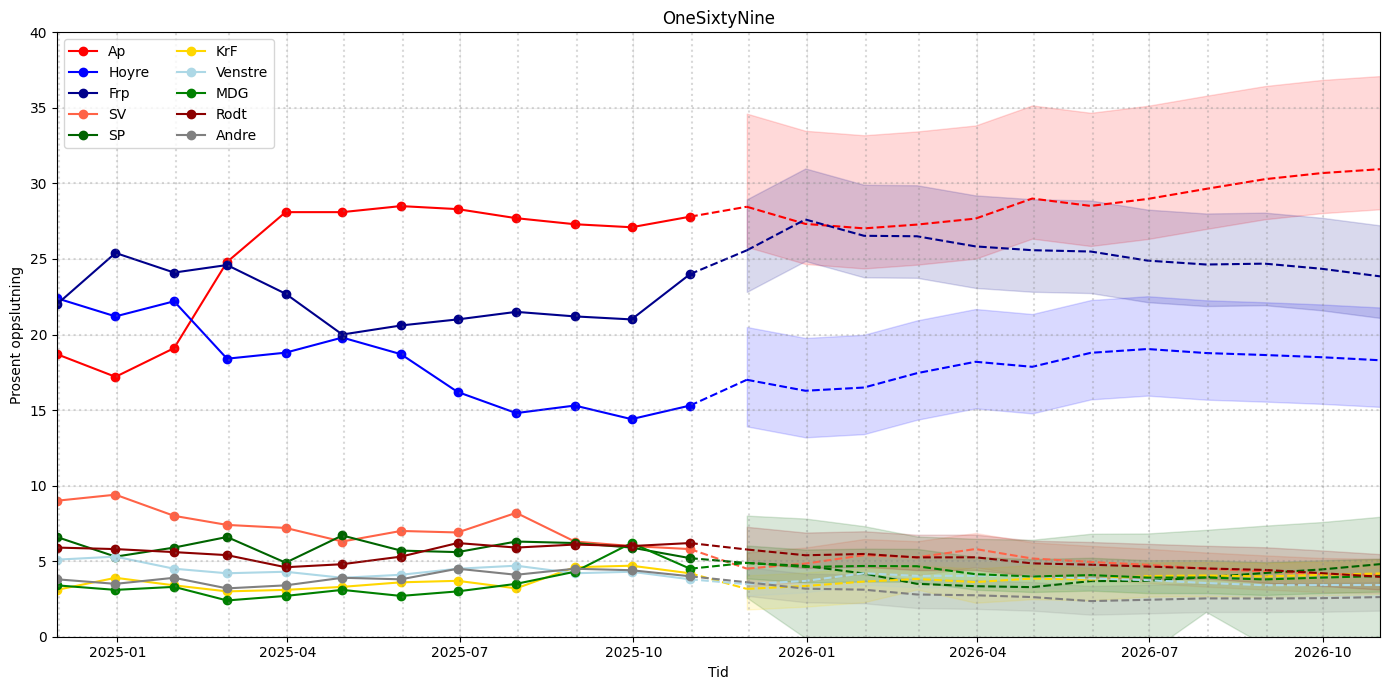

In [9]:
# --- Define colors for consistency ---
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


# --- Plot ---
plt.figure(figsize=(14, 7))

months_back = 12
df_recent = df.iloc[-months_back:]  # last 12 months actual

for party, color in colors.items():

    # Actual observed data
    plt.plot(
        df_recent.index,
        df_recent[party],
        marker="o",
        color=color,
        label=f"{party}"
    )

    # Forecast line (bootstrap mean)
    plt.plot(
        forecast_df.index,
        forecast_df[party],
        linestyle="dashed",
        color=color
    )

    # Connect last actual point to first forecast
    plt.plot(
        [df_recent.index[-1], forecast_df.index[0]],
        [df_recent[party].iloc[-1], forecast_df[party].iloc[0]],
        linestyle="dashed",
        color=color
    )

    # Confidence interval (bootstrap)
    plt.fill_between(
        forecast_df.index,
        forecast_lower_df[party],
        forecast_upper_df[party],
        color=color,
        alpha=0.15
    )

# --- Vertical monthly guides ---
dates = pd.date_range(start=df_recent.index[0], end=forecast_df.index[-1], freq="MS")
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.3)

# --- Horizontal percentage lines ---
for percent in range(0, 45, 5):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.3)

# --- Final formatting ---
plt.xlim(df_recent.index[0], forecast_df.index[-1])
plt.ylim(0, 40)
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine")
plt.legend(loc="upper left", ncol=2)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [10]:
def backtest_hybrid(df, horizon=3, lags_ML=18):
    errors_var = []
    errors_hybrid = []

    for t in range(48, len(df)-horizon):  # start after ~4 years to stabilize VAR
        train = df.iloc[:t]

        # --- Fit VAR ---
        var_res = VAR(train).fit(maxlags=6)
        var_pred = var_res.forecast(train.values[-var_res.k_ar:], steps=horizon)[-1]

        # --- ML residuals ---
        full_resid = train.iloc[var_res.k_ar:].values - var_res.fittedvalues.values
        
        X_train = []
        y_train = []
        for i in range(lags_ML, len(train)):
            X_train.append(train.iloc[i-lags_ML:i].values.flatten())
            y_train.append(full_resid[i - var_res.k_ar])

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        xgb = XGBRegressor(
            n_estimators=300, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8
        )
        xgb.fit(X_train, y_train)

        # predict ML residual for horizon
        win = train.values[-lags_ML:].copy()
        for _ in range(horizon):
            pred_res = xgb.predict(win.flatten().reshape(1, -1))[0]
            next_point = var_pred  # VAR forecast for this step
            win = np.vstack([win[1:], next_point])

        hybrid_pred = var_pred + pred_res
        
        # true y
        y_true = df.iloc[t + horizon - 1].values

        # record errors
        errors_var.append(np.abs(y_true - var_pred))
        errors_hybrid.append(np.abs(y_true - hybrid_pred))

    return np.array(errors_var), np.array(errors_hybrid)


In [11]:
err_var, err_hybrid = backtest_hybrid(df)

mape_var = err_var.mean(axis=0)
mape_hybrid = err_hybrid.mean(axis=0)

improvement = (mape_var - mape_hybrid) / mape_var * 100

pd.DataFrame({
    "VAR_MAPE": mape_var,
    "Hybrid_MAPE": mape_hybrid,
    "Improvement_%": improvement
}, index=df.columns)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

,VAR_MAPE,Hybrid_MAPE,Improvement_%
Ap,2.296425,2.239360,2.484955
Hoyre,2.499750,2.434284,2.618877
Frp,1.941751,1.956172,-0.742692
SV,0.674103,0.668566,0.821282
SP,1.268507,1.250076,1.452961
KrF,0.395029,0.393397,0.413140
Venstre,0.497791,0.492349,1.093340
MDG,0.681372,0.651645,4.362769
Rodt,0.634849,0.677416,-6.705133
Andre,0.559170,0.534275,4.452142
